In [ ]:
!date

In [2]:
%cd /Users/rpark/Documents/UChicago/Year\ 3/Mathematical\ Methods\ for\ Biological\ Sciences\ II/CP_2023/notebooks/jaccardDistort/densvis


/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/notebooks/jaccardDistort/densvis


In [3]:
#Required packages
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun


In [6]:
%cd ../../

/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/notebooks


In [7]:
!gunzip *.gz

zsh:1: no matches found: *.gz


In [6]:
%cd /Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/scripts

/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/scripts


In [5]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

# Install Packages

In [7]:
import networkx as nx
import anndata 
import pandas as pd
import numpy as np

import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
import matplotlib.patches as patches
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


In [8]:
sc.set_figure_params(dpi=125)

# Find KNN Jaccard Distances with Ambient Space in Latent Spaces

In [22]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = "/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/notebooks/jaccardDistort/theirdata"

pcs = 50
n_latent = 50

## Make 15/50/100D Embeddings, 2D t-SNE/UMAP from all PCA Projections
Unchanged functions; annotations are added by us. 

In [10]:
#for a set of 30 nearest neighbors KNN, what are the jaccard distances before and after the dimensionality reduction? 

#orig_indices is the ambient
def getJac(orig_indices,latents, latentLab, n_neighbors=30,set_p=1):
  emb = []

  xs = []

  ys = []

#Initialize k-nearest neighbor dataframe
  knnDF = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
#finds n neighbors (can't find documentation on this)
    ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=set_p)
#Calculates Jaccard between two vectors
    x = tl.getJaccard(orig_indices,ind)
#Appends jaccard distance to x list
    xs += x
    #ys += list(y)
#Label / embedding added as label to jaccard distance. 
    emb += [l]*len(x)
#prints out the label
    print(l)
#prints out the mean score for the embedding
    print(np.mean(tl.getJaccard(orig_indices,ind)))


#jaccard distances
  knnDF['x'] = xs
  #knnDF['y'] = ys
#embedding labels
  knnDF['latent'] = emb

  return knnDF

In [11]:
#takes scaled counts matrix, logged counts matrix, ndims (cells & genes), # of PCs to select, rounds, what is p?
#returns the ambient distances I believe
def latentComp(scaled_mat, log_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=1):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  orig_indices = tl.getNeighbors(log_mat, n_neigh = 30,p=set_p)
#For each round
  for i in range(rounds):
#for each set of PCs
    for j in pcs:
#PCA is a special case of SVD, since data is normalized and scaled already we can use SVD (i think) 
      tsvd = TruncatedSVD(n_components=j) #
      x_pca = tsvd.fit_transform(scaled_mat)
    #PCA=>UMAP
      pcaUMAP = reducer.fit_transform(x_pca)
      #pcaDensUMAP = densUMAP.fit_transform(x_pca)
    #PCA=>TSNE
      pcaTSNE = tsne.fit_transform(x_pca)
    #append all reductions to latents matrix. 
      latents += [x_pca,pcaTSNE, pcaUMAP]
    #Append labels to label column
      latentLab += ['PCA '+str(j)+'D','PCA '+str(j)+'D t-SNE','PCA '+str(j)+'D UMAP']
      latentType += [str(j)+'D','2D','2D']


#2D PCA, no additional reduction
    pcaTSNE = tsne.fit_transform(x_pca)
    pcaUMAP = reducer.fit_transform(x_pca)

    tsvd = TruncatedSVD(n_components=2)
    x_pca = tsvd.fit_transform(scaled_mat)

    latents += [x_pca, pcaTSNE, pcaUMAP]
    latentLab += ['PCA 2D','t-SNE 2D','UMAP 2D']
    latentType += ['2D','2D','2D']
#jaccard distances from the ambient to the reduction
  df = getJac(orig_indices,latents, latentLab, 30)


  return df

In [12]:
def latentPCAComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3, set_p=1):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  frames = []

  for j in pcs:

    tsvd = TruncatedSVD(n_components=j)
    x_pca = tsvd.fit_transform(scaled_mat)
    
    orig_indices = tl.getNeighbors(x_pca, n_neigh = 30,p=set_p)

    for i in range(rounds):

      
      pcaUMAP = reducer.fit_transform(x_pca)
      #pcaDensUMAP = densUMAP.fit_transform(x_pca)

      pcaTSNE = tsne.fit_transform(x_pca)

      latents += [pcaTSNE, pcaUMAP]
      latentLab += ['PCA '+str(j)+'D t-SNE','PCA '+str(j)+'D UMAP']
      latentType += ['2D','2D']

      frames += [getJac(orig_indices,latents, latentLab, 30)]

      res = pd.concat(frames)


  return res

## Read in Data

### Their data: Read in SMART-Seq VMH data
Preserved to test & make sure code works. 

In [23]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [24]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [18]:
meta = pd.read_csv(data_path+'/smartmetadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


In [19]:
print(meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1])
print(meta.sex_label.value_counts()[1])

7.406113537117904
458


In [20]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)

allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

In [21]:
#Get KNN Jaccard distances
smartAmb = latentComp(scaled_mat,count_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(smartAmb.head())
smartPCAAmb = latentPCAComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(smartPCAAmb.head())

/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anac

PCA 15D
0.7102322431835096
PCA 15D t-SNE
0.7816641863619489
PCA 15D UMAP
0.7903573174297073
PCA 50D
0.6346498863370759
PCA 50D t-SNE
0.7313319812028628
PCA 50D UMAP
0.7519759091259085
PCA 100D
0.6390192557902227
PCA 100D t-SNE
0.7230696419953956
PCA 100D UMAP
0.7455329782697719
PCA 2D
0.9455064286188577
t-SNE 2D
0.723415767400077
UMAP 2D
0.7471952856356006
PCA 15D
0.7101633627330987
PCA 15D t-SNE
0.7812766902604914
PCA 15D UMAP
0.7937380832587504
PCA 50D
0.6326952957867858
PCA 50D t-SNE
0.7279559873721382
PCA 50D UMAP
0.7500644979123734
PCA 100D
0.6402933772121736
PCA 100D t-SNE
0.72070446580388
PCA 100D UMAP
0.7459852772292875
PCA 2D
0.9455216576251217
t-SNE 2D
0.7208171236378876
UMAP 2D
0.747628257916524
PCA 15D
0.7103512858514147
PCA 15D t-SNE
0.7821033921379396
PCA 15D UMAP
0.791997620134588
PCA 50D
0.6325759744258889
PCA 50D t-SNE
0.7310304377518257
PCA 50D UMAP
0.7510349167675003
PCA 100D
0.6405079320291716
PCA 100D t-SNE
0.7229951235936364
PCA 100D UMAP
0.7445108088000607
PCA 2D

/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6012313108195206
PCA 15D UMAP
0.6435698261733966


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6012313108195206
PCA 15D UMAP
0.6435698261733966
PCA 15D t-SNE
0.6003122626615505
PCA 15D UMAP
0.6437561229135206


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6012313108195206
PCA 15D UMAP
0.6435698261733966
PCA 15D t-SNE
0.6003122626615505
PCA 15D UMAP
0.6437561229135206
PCA 15D t-SNE
0.5986878803120332
PCA 15D UMAP
0.6457686601958548


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6819392292034382
PCA 15D UMAP
0.7082835947370992
PCA 15D t-SNE
0.682123076435499
PCA 15D UMAP
0.7085892046232566
PCA 15D t-SNE
0.677247000612839
PCA 15D UMAP
0.7084283331867969
PCA 50D t-SNE
0.6177174630177069
PCA 50D UMAP
0.6670706669045251


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6819392292034382
PCA 15D UMAP
0.7082835947370992
PCA 15D t-SNE
0.682123076435499
PCA 15D UMAP
0.7085892046232566
PCA 15D t-SNE
0.677247000612839
PCA 15D UMAP
0.7084283331867969
PCA 50D t-SNE
0.6177174630177069
PCA 50D UMAP
0.6670706669045251
PCA 50D t-SNE
0.6182930813767497
PCA 50D UMAP
0.6674043692070074


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6819392292034382
PCA 15D UMAP
0.7082835947370992
PCA 15D t-SNE
0.682123076435499
PCA 15D UMAP
0.7085892046232566
PCA 15D t-SNE
0.677247000612839
PCA 15D UMAP
0.7084283331867969
PCA 50D t-SNE
0.6177174630177069
PCA 50D UMAP
0.6670706669045251
PCA 50D t-SNE
0.6182930813767497
PCA 50D UMAP
0.6674043692070074
PCA 50D t-SNE
0.6183654171518649
PCA 50D UMAP
0.6641773598289088


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7286156860937165
PCA 15D UMAP
0.7495236126811896
PCA 15D t-SNE
0.728247351662255
PCA 15D UMAP
0.7490606583344995
PCA 15D t-SNE
0.7240865780378664
PCA 15D UMAP
0.7494465440187246
PCA 50D t-SNE
0.6699107823100139
PCA 50D UMAP
0.7089995795032044
PCA 50D t-SNE
0.670777024474395
PCA 50D UMAP
0.7097794649854338
PCA 50D t-SNE
0.6703679048234654
PCA 50D UMAP
0.7073941395867995
PCA 100D t-SNE
0.6652425331950826
PCA 100D UMAP
0.7129927166568437


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7286156860937165
PCA 15D UMAP
0.7495236126811896
PCA 15D t-SNE
0.728247351662255
PCA 15D UMAP
0.7490606583344995
PCA 15D t-SNE
0.7240865780378664
PCA 15D UMAP
0.7494465440187246
PCA 50D t-SNE
0.6699107823100139
PCA 50D UMAP
0.7089995795032044
PCA 50D t-SNE
0.670777024474395
PCA 50D UMAP
0.7097794649854338
PCA 50D t-SNE
0.6703679048234654
PCA 50D UMAP
0.7073941395867995
PCA 100D t-SNE
0.6652425331950826
PCA 100D UMAP
0.7129927166568437
PCA 100D t-SNE
0.6626992476808361
PCA 100D UMAP
0.7113341415174644


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7286156860937165
PCA 15D UMAP
0.7495236126811896
PCA 15D t-SNE
0.728247351662255
PCA 15D UMAP
0.7490606583344995
PCA 15D t-SNE
0.7240865780378664
PCA 15D UMAP
0.7494465440187246
PCA 50D t-SNE
0.6699107823100139
PCA 50D UMAP
0.7089995795032044
PCA 50D t-SNE
0.670777024474395
PCA 50D UMAP
0.7097794649854338
PCA 50D t-SNE
0.6703679048234654
PCA 50D UMAP
0.7073941395867995
PCA 100D t-SNE
0.6652425331950826
PCA 100D UMAP
0.7129927166568437
PCA 100D t-SNE
0.6626992476808361
PCA 100D UMAP
0.7113341415174644
PCA 100D t-SNE
0.6633589078567782
PCA 100D UMAP
0.7109340643744733
          x         latent
0  0.909091  PCA 15D t-SNE
1  0.636364  PCA 15D t-SNE
2  0.666667  PCA 15D t-SNE
3  0.604651  PCA 15D t-SNE
4  0.666667  PCA 15D t-SNE


In [24]:
smartPCAAmb.to_csv('allOuts/smartPCAAmb.csv')
smartAmb.to_csv('allOuts/smartAmb.csv')


# Our Data

## Cellular Taxonomy of the Mouse Striatum as Revealed by Single-Cell RNAseq (GSE82187)


In [27]:
#Change to directory with data
%cd /Users/rpark/Documents/UChicago/Year\ 3/Mathematical\ Methods\ for\ Biological\ Sciences\ II/CP_2023/notebooks/jaccardDistort/ourdata
!gunzip *.gz

/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/notebooks/jaccardDistort/ourdata
zsh:1: no matches found: *.gz


In [28]:
#Read in data, check shape
striat = pd.read_csv('GSE82187_cast_all_forGEO.csv')

In [326]:
striat.shape

(1208, 18845)

In [328]:
np.unique(striat.type)

array(['Astro', 'Ependy-C', 'Ependy-Sec', 'Macrophage', 'Microglia',
       'NSC', 'Neuron', 'OPC', 'Oligo', 'Vascular'], dtype=object)

In [29]:
#Reduce original dataframe to counts matrix.
count_mat = striat.drop(['Unnamed: 0','cell.name','type','experiment','protocol'],axis=1).values
#Scale data
scaled_mat = scale(count_mat)

In [31]:
#Calculate KNN Jaccard Distance, Ambient
striatAmb = latentComp(scaled_mat,count_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(striatAmb.head())

In [102]:
#Calculate KNN Jaccard Distance, Reduced
striatPCAAmb = latentPCAComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(striatPCAAmb.head())

In [38]:
#Saving the outputs
#Comparison of nearest neighbor Jaccard distances to the ambient space
striatAmb.to_csv('striatAmb.csv')
#Comparison of nearest neighbor Jaccard distances to high dimensional 50D PCA space
striatPCAAmb.to_csv('striatPCAAmb.csv')

## Kernel Density Plot Representations, comparison to ambient space

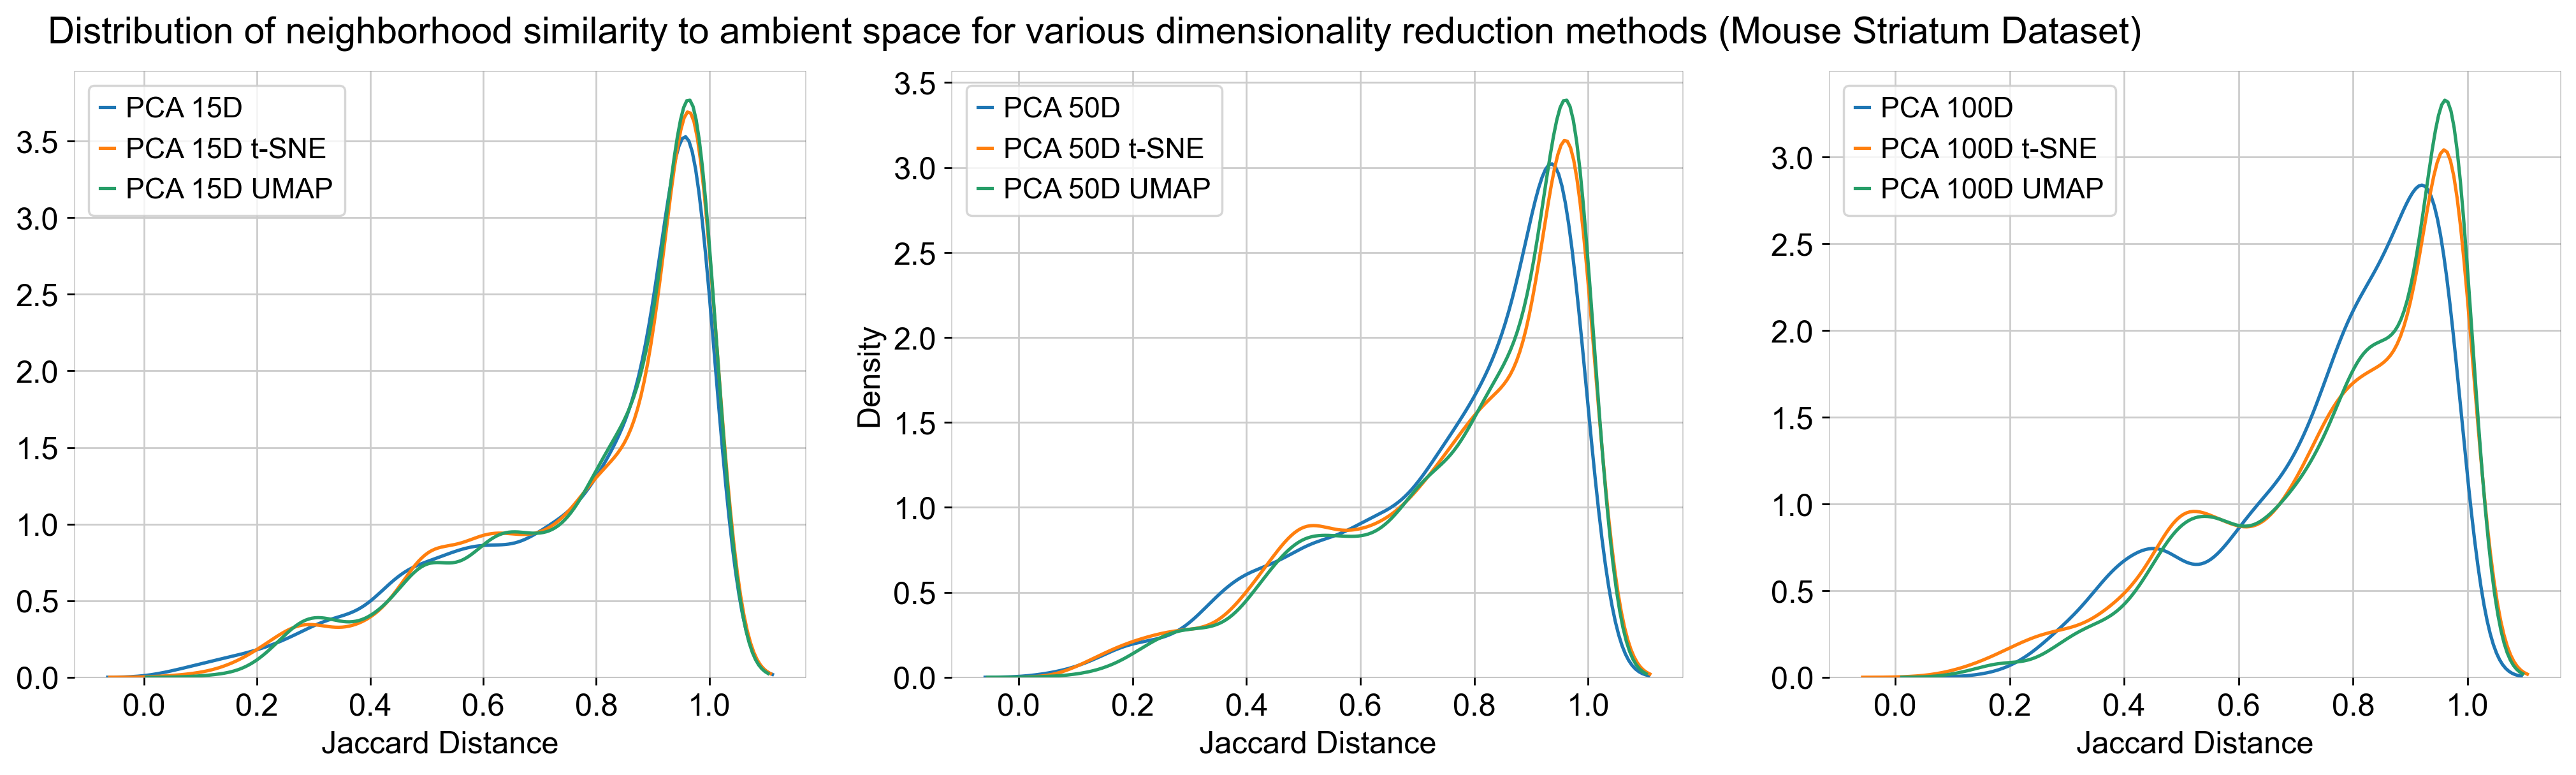

In [325]:
#Kernel Density Aggregate Plots
plt.figure(figsize = (20,5))
plt.suptitle("Distribution of neighborhood similarity to ambient space for various dimensionality reduction methods (Mouse Striatum Dataset)",
            horizontalalignment='center')
plt.subplot(132)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 50D'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 50D t-SNE'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 50D UMAP'].x)
plt.xlabel("Jaccard Distance")
plt.legend(['PCA 50D','PCA 50D t-SNE','PCA 50D UMAP'])

plt.subplot(131)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 15D'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 15D t-SNE'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 15D UMAP'].x)
plt.xlabel("Jaccard Distance")
plt.legend(['PCA 15D','PCA 15D t-SNE','PCA 15D UMAP'])
plt.ylabel('')

plt.subplot(133)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 100D'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 100D t-SNE'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 100D UMAP'].x)
plt.ylabel('')
plt.legend(['PCA 100D','PCA 100D t-SNE','PCA 100D UMAP'])
plt.xlabel("Jaccard Distance")
plt.show()

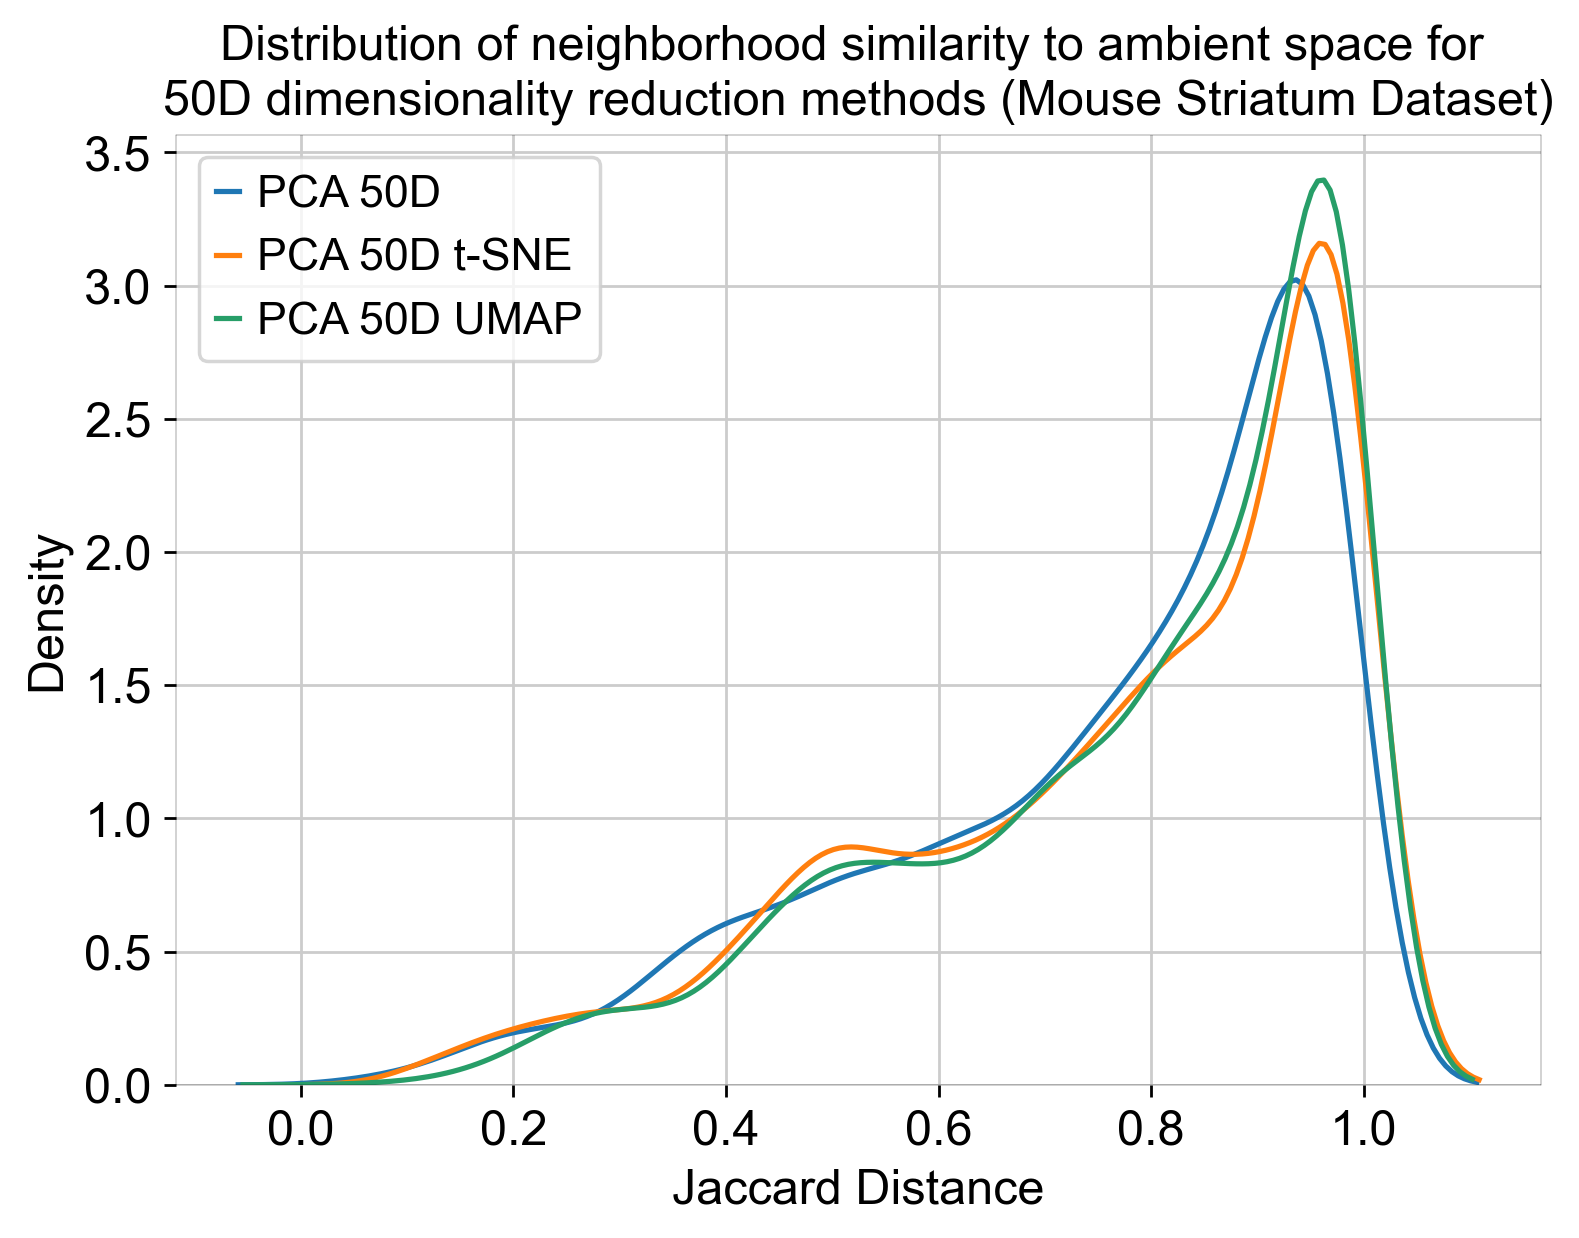

In [158]:
#Figure 1a
plt.figure(figsize = (7,5))
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 50D'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 50D t-SNE'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 50D UMAP'].x)
plt.legend(['PCA 50D','PCA 50D t-SNE','PCA 50D UMAP'])
plt.ylabel("Density")
plt.xlabel("Jaccard Distance")
plt.title("Distribution of neighborhood similarity to ambient space for \n50D dimensionality reduction methods (Mouse Striatum Dataset)")
plt.show()

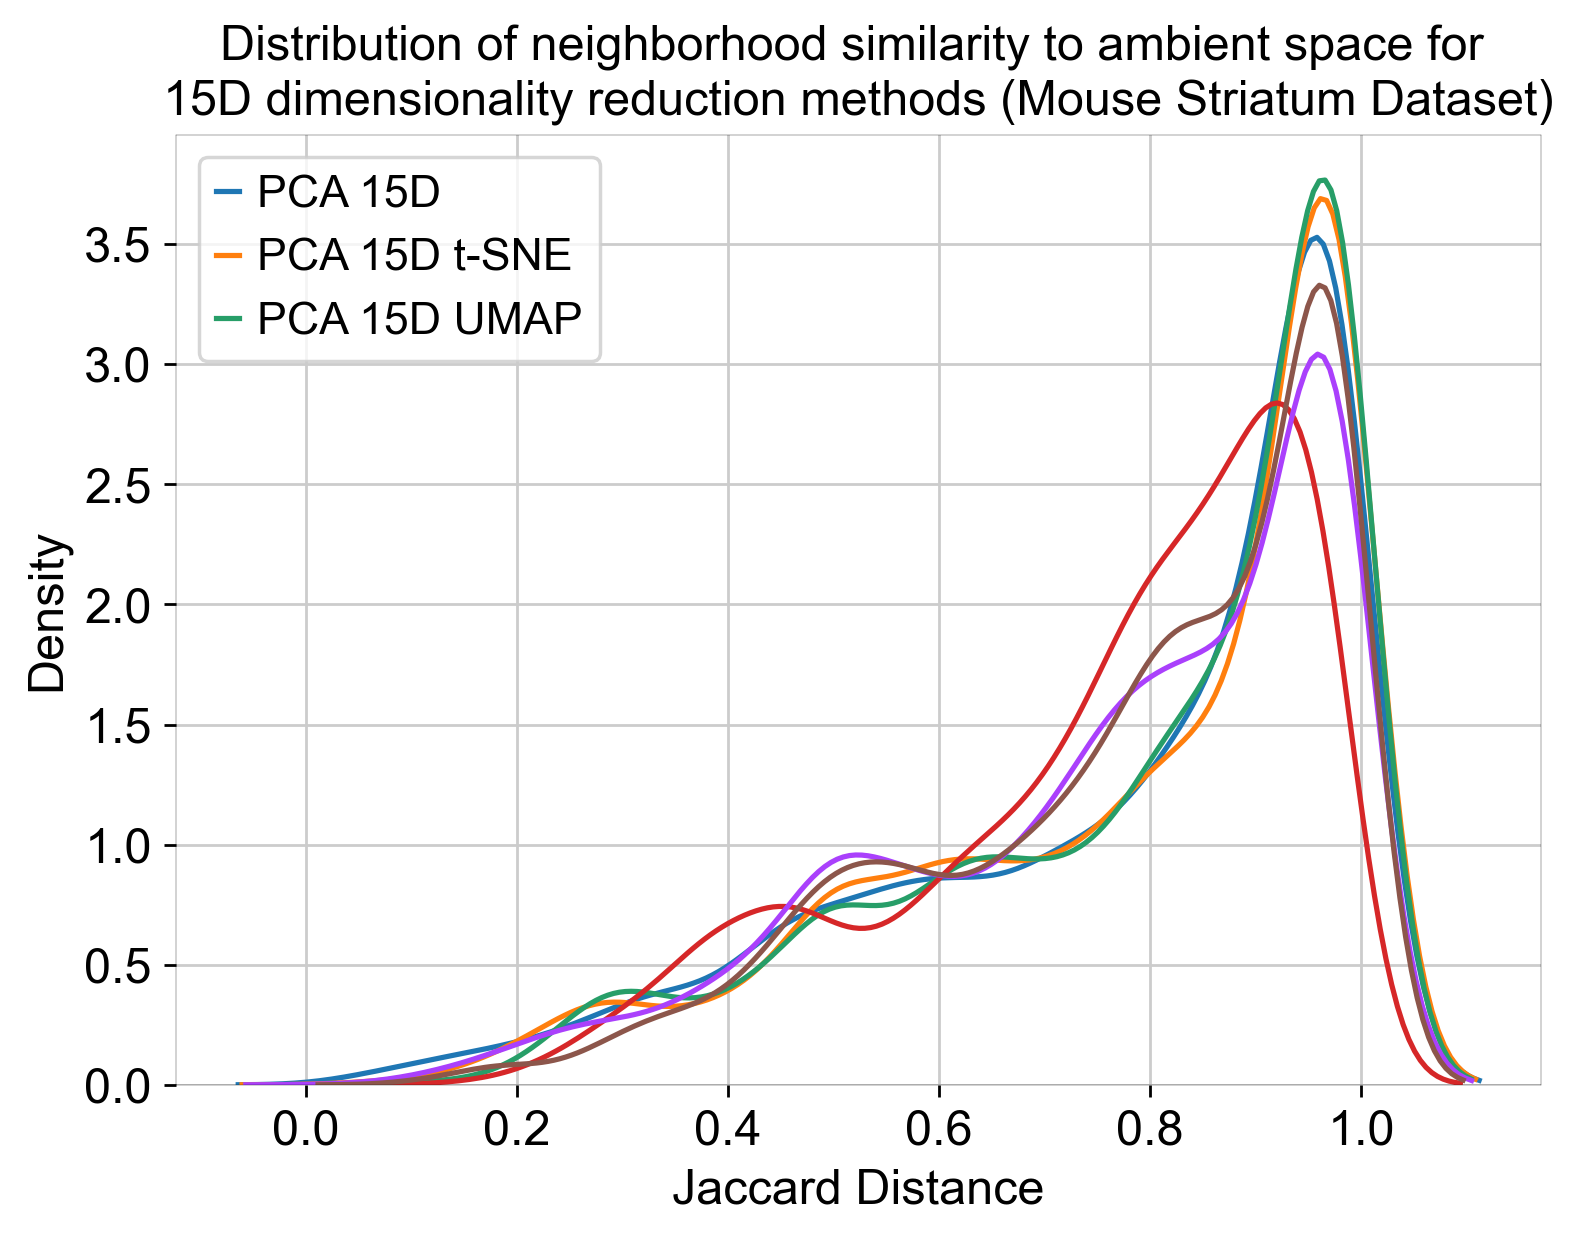

In [308]:
#Figure 1b
plt.figure(figsize = (7,5))
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 15D'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 15D t-SNE'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 15D UMAP'].x)
plt.legend(['PCA 15D','PCA 15D t-SNE','PCA 15D UMAP'])
plt.ylabel("Density")
plt.xlabel("Jaccard Distance")
plt.title("Distribution of neighborhood similarity to ambient space for \n15D dimensionality reduction methods (Mouse Striatum Dataset)")
plt.show()

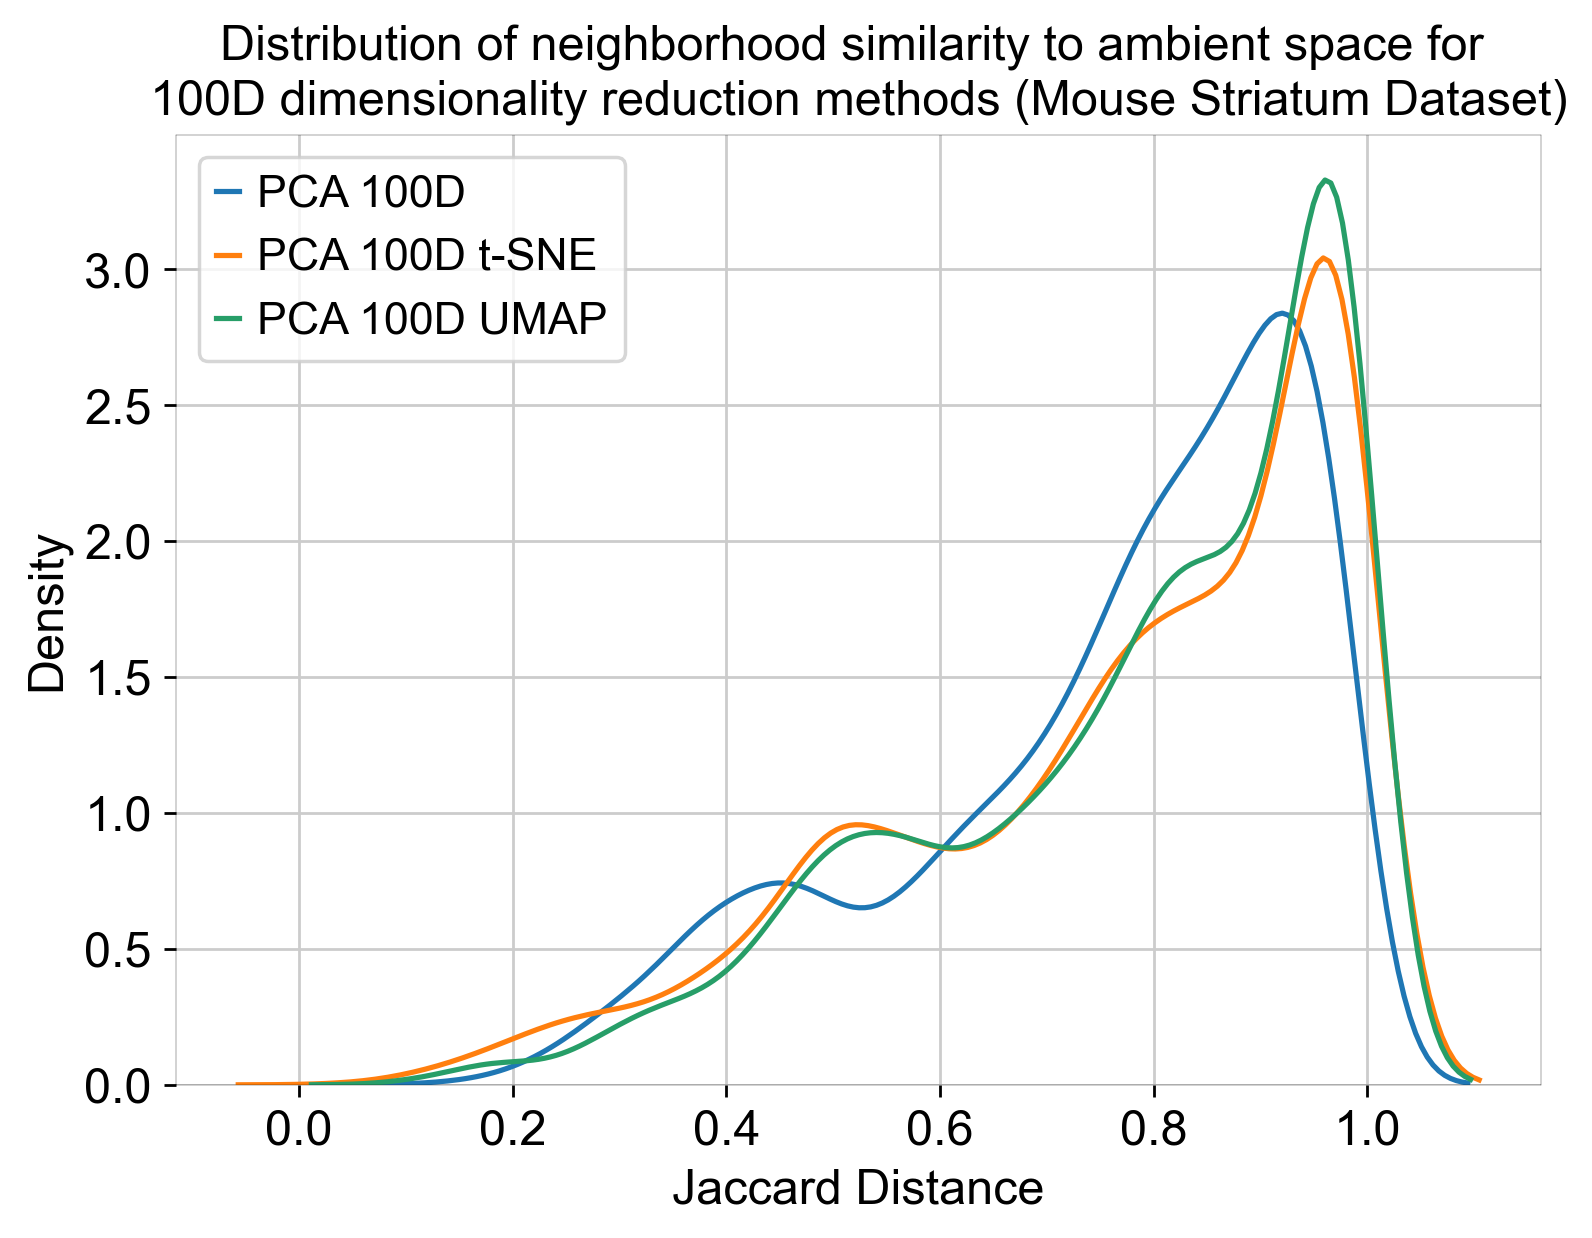

In [156]:
#Figure 1c
plt.figure(figsize = (7,5))
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 100D'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 100D t-SNE'].x)
sns.kdeplot(striatAmb.loc[striatAmb.latent=='PCA 100D UMAP'].x)
plt.legend(['PCA 100D','PCA 100D t-SNE','PCA 100D UMAP'])
plt.ylabel("Density")
plt.xlabel("Jaccard Distance")
plt.title("Distribution of neighborhood similarity to ambient space for \n100D dimensionality reduction methods (Mouse Striatum Dataset)")
plt.show()

## Single Cell and Spatial Analysis of Human Squamous Cell Carcinoma: GSE144240


In [35]:
#Change to directory with data
%cd /Users/rpark/Documents/UChicago/Year\ 3/Mathematical\ Methods\ for\ Biological\ Sciences\ II/CP_2023/notebooks/jaccardDistort/ourdata/GSE144240_RAW
!gunzip *.gz

/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/notebooks/jaccardDistort/ourdata/GSE144240_RAW
GSM4284322_P9_ST_rep1_stdata.tsv already exists -- do you wish to overwrite (y or n)? ^C
zsh:1: command not found: y


### Sample GSM4284316

In [107]:
squam = pd.read_table('GSM4284316_P2_ST_rep1_stdata.tsv')

In [154]:
squam.shape

(1933, 17139)

In [114]:
#Get counts matrix
count_mat = squam.drop('Unnamed: 0',axis=1).values
#scaled counts matrix
scaled_mat = scale(count_mat)

In [115]:
#Calculate KNN Jaccard Distance, Ambient
squamAmb = latentComp(scaled_mat,count_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(squamAmb.head())

/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anac

PCA 15D
0.8628039624228867
PCA 15D t-SNE
0.8715418640161143
PCA 15D UMAP
0.8802380444546103
PCA 50D
0.872951743160675
PCA 50D t-SNE
0.8687874692905544
PCA 50D UMAP
0.880063468249193
PCA 100D
0.8946895343617928
PCA 100D t-SNE
0.8718868936184766
PCA 100D UMAP
0.8801766146796695
PCA 2D
0.8838864948081917
t-SNE 2D
0.8744839950375609
UMAP 2D
0.882117482637619
PCA 15D
0.8620940037106799
PCA 15D t-SNE
0.872662453043861
PCA 15D UMAP
0.8803077339363126
PCA 50D
0.8742661194852553
PCA 50D t-SNE
0.8691290708222275
PCA 50D UMAP
0.8793162696303665
PCA 100D
0.8942550737770869
PCA 100D t-SNE
0.8728899246684025
PCA 100D UMAP
0.8809155651540499
PCA 2D
0.8838958837478331
t-SNE 2D
0.8735812623733479
UMAP 2D
0.8822195391808475
PCA 15D
0.8622306834113135
PCA 15D t-SNE
0.8706904474569734
PCA 15D UMAP
0.8787671787493335
PCA 50D
0.8747587384419081
PCA 50D t-SNE
0.871137180771787
PCA 50D UMAP
0.8796159258708026
PCA 100D
0.8948813191043111
PCA 100D t-SNE
0.8718333533573076
PCA 100D UMAP
0.8830015741738371
PCA 2D

In [116]:
#Calculate KNN Jaccard Distance, Reduced
squamPCAAmb = latentPCAComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(squamPCAAmb.head())

/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6612142476739626
PCA 15D UMAP
0.7024817109500273


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6612142476739626
PCA 15D UMAP
0.7024817109500273
PCA 15D t-SNE
0.6630697006350862
PCA 15D UMAP
0.7011178828933455


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.6612142476739626
PCA 15D UMAP
0.7024817109500273
PCA 15D t-SNE
0.6630697006350862
PCA 15D UMAP
0.7011178828933455
PCA 15D t-SNE
0.6628751052308574
PCA 15D UMAP
0.7032093078054599


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7827375927536918
PCA 15D UMAP
0.8026823859636423
PCA 15D t-SNE
0.7828232008795801
PCA 15D UMAP
0.8021390463793141
PCA 15D t-SNE
0.7835199630138484
PCA 15D UMAP
0.8014662121296208
PCA 50D t-SNE
0.7597663210810701
PCA 50D UMAP
0.7946400362077715


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7827375927536918
PCA 15D UMAP
0.8026823859636423
PCA 15D t-SNE
0.7828232008795801
PCA 15D UMAP
0.8021390463793141
PCA 15D t-SNE
0.7835199630138484
PCA 15D UMAP
0.8014662121296208
PCA 50D t-SNE
0.7597663210810701
PCA 50D UMAP
0.7946400362077715
PCA 50D t-SNE
0.7602271320698796
PCA 50D UMAP
0.7917013043231467


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7827375927536918
PCA 15D UMAP
0.8026823859636423
PCA 15D t-SNE
0.7828232008795801
PCA 15D UMAP
0.8021390463793141
PCA 15D t-SNE
0.7835199630138484
PCA 15D UMAP
0.8014662121296208
PCA 50D t-SNE
0.7597663210810701
PCA 50D UMAP
0.7946400362077715
PCA 50D t-SNE
0.7602271320698796
PCA 50D UMAP
0.7917013043231467
PCA 50D t-SNE
0.7589807466887524
PCA 50D UMAP
0.7927236887693696


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.8537694893975968
PCA 15D UMAP
0.8644755182416974
PCA 15D t-SNE
0.8532227039335047
PCA 15D UMAP
0.8640171055812681
PCA 15D t-SNE
0.853293873205949
PCA 15D UMAP
0.8637496584635037
PCA 50D t-SNE
0.83512933053948
PCA 50D UMAP
0.8535267740691748
PCA 50D t-SNE
0.8360864875827035
PCA 50D UMAP
0.8526342309648061
PCA 50D t-SNE
0.8355164456798042
PCA 50D UMAP
0.8535586915118027
PCA 100D t-SNE
0.8204826081541988
PCA 100D UMAP
0.8487827797866264


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.8537694893975968
PCA 15D UMAP
0.8644755182416974
PCA 15D t-SNE
0.8532227039335047
PCA 15D UMAP
0.8640171055812681
PCA 15D t-SNE
0.853293873205949
PCA 15D UMAP
0.8637496584635037
PCA 50D t-SNE
0.83512933053948
PCA 50D UMAP
0.8535267740691748
PCA 50D t-SNE
0.8360864875827035
PCA 50D UMAP
0.8526342309648061
PCA 50D t-SNE
0.8355164456798042
PCA 50D UMAP
0.8535586915118027
PCA 100D t-SNE
0.8204826081541988
PCA 100D UMAP
0.8487827797866264
PCA 100D t-SNE
0.821655386748387
PCA 100D UMAP
0.8498133497352959


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.8537694893975968
PCA 15D UMAP
0.8644755182416974
PCA 15D t-SNE
0.8532227039335047
PCA 15D UMAP
0.8640171055812681
PCA 15D t-SNE
0.853293873205949
PCA 15D UMAP
0.8637496584635037
PCA 50D t-SNE
0.83512933053948
PCA 50D UMAP
0.8535267740691748
PCA 50D t-SNE
0.8360864875827035
PCA 50D UMAP
0.8526342309648061
PCA 50D t-SNE
0.8355164456798042
PCA 50D UMAP
0.8535586915118027
PCA 100D t-SNE
0.8204826081541988
PCA 100D UMAP
0.8487827797866264
PCA 100D t-SNE
0.821655386748387
PCA 100D UMAP
0.8498133497352959
PCA 100D t-SNE
0.8209994512554316
PCA 100D UMAP
0.8490980751830433
          x         latent
0  0.695652  PCA 15D t-SNE
1  0.823529  PCA 15D t-SNE
2  0.604651  PCA 15D t-SNE
3  0.695652  PCA 15D t-SNE
4  0.867925  PCA 15D t-SNE


In [122]:
!cd /Users/rpark/Documents/UChicago/Year\ 3/Mathematical\ Methods\ for\ Biological\ Sciences\ II/CP_2023/notebooks/jaccardDistort/ourdata/jaccard_out

zsh:cd:1: too many arguments


In [119]:
#Saving the outputs
#Comparison of nearest neighbor Jaccard distances to the ambient space
squamAmb.to_csv('squamAmb.csv')
#Comparison of nearest neighbor Jaccard distances to high dimensional 50D PCA space
squamPCAAmb.to_csv('squamPCAAmb.csv')

### Figures
Average Jaccard Distances

## Single cell transcriptome profiling of retinal ganglion cells identifies cellular subtypes (GSE115404)

GSM3177677	Left RGCs

GSM3177678	Right RGCs


In [126]:
#Change to directory with data
%cd /Users/rpark/Documents/UChicago/Year\ 3/Mathematical\ Methods\ for\ Biological\ Sciences\ II/CP_2023/notebooks/jaccardDistort/ourdata

/Users/rpark/Documents/UChicago/Year 3/Mathematical Methods for Biological Sciences II/CP_2023/notebooks/jaccardDistort/ourdata


In [137]:
rcg = pd.read_csv('GSE115404_AllCells.csv')
print(rcg.shape)

(13618, 6227)


In [139]:
#dataset is too big... sample half
rcg = rcg.sample(6809)
rcg.shape

(6809, 6227)

In [140]:
#counts matrix
count_mat = rcg.drop(['X','Avg'],axis=1).values
#scaled counts matrix
scaled_mat = scale(count_mat)

In [141]:
#Calculate KNN Jaccard Distance, Ambient
rcgAmb = latentComp(scaled_mat,count_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(rcgAmb.head())

/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anac

PCA 15D
0.9108285882307082
PCA 15D t-SNE
0.9306055095840586
PCA 15D UMAP
0.9385547161301164
PCA 50D
0.900838863240931
PCA 50D t-SNE
0.9310331417635321
PCA 50D UMAP
0.9393914659568693
PCA 100D
0.8738072451624437
PCA 100D t-SNE
0.930753795757248
PCA 100D UMAP
0.9395836860808312
PCA 2D
0.9361688413926028
t-SNE 2D
0.9302765613940437
UMAP 2D
0.9391075670133795
PCA 15D
0.9108379694757498
PCA 15D t-SNE
0.9312825932289849
PCA 15D UMAP
0.9389003913496065
PCA 50D
0.9007524338850744
PCA 50D t-SNE
0.9312981682059692
PCA 50D UMAP
0.9395816106398712
PCA 100D
0.8756717230573892
PCA 100D t-SNE
0.9308011923828662
PCA 100D UMAP
0.9394174167543622
PCA 2D
0.9361688413926028
t-SNE 2D
0.9302403361884514
UMAP 2D
0.9396075748855521
PCA 15D
0.9108901658719826
PCA 15D t-SNE
0.9311389264596455
PCA 15D UMAP
0.9389359325188894
PCA 50D
0.9010055342891585
PCA 50D t-SNE
0.930724341207497
PCA 50D UMAP
0.939818375801922
PCA 100D
0.8742965114216268
PCA 100D t-SNE
0.9308463597957098
PCA 100D UMAP
0.9403235251263112
PCA 2

In [142]:
#Calculate KNN Jaccard Distance, Reduced
rcgPCAAmb = latentPCAComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3,set_p=2)
print(rcgPCAAmb.head())


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7296203379162705
PCA 15D UMAP
0.7886278648865724


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7296203379162705
PCA 15D UMAP
0.7886278648865724
PCA 15D t-SNE
0.7301478768530832
PCA 15D UMAP
0.7890537564314819


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7296203379162705
PCA 15D UMAP
0.7886278648865724
PCA 15D t-SNE
0.7301478768530832
PCA 15D UMAP
0.7890537564314819
PCA 15D t-SNE
0.7293277502558945
PCA 15D UMAP
0.7880615508054246


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7987343948470405
PCA 15D UMAP
0.8357486751140183
PCA 15D t-SNE
0.7991792690255863
PCA 15D UMAP
0.8361560662130018
PCA 15D t-SNE
0.7986595726450922
PCA 15D UMAP
0.8350314246910857
PCA 50D t-SNE
0.7935200870018785
PCA 50D UMAP
0.8382325442681541


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7987343948470405
PCA 15D UMAP
0.8357486751140183
PCA 15D t-SNE
0.7991792690255863
PCA 15D UMAP
0.8361560662130018
PCA 15D t-SNE
0.7986595726450922
PCA 15D UMAP
0.8350314246910857
PCA 50D t-SNE
0.7935200870018785
PCA 50D UMAP
0.8382325442681541
PCA 50D t-SNE
0.7928201387323008
PCA 50D UMAP
0.8380000344424547


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.7987343948470405
PCA 15D UMAP
0.8357486751140183
PCA 15D t-SNE
0.7991792690255863
PCA 15D UMAP
0.8361560662130018
PCA 15D t-SNE
0.7986595726450922
PCA 15D UMAP
0.8350314246910857
PCA 50D t-SNE
0.7935200870018785
PCA 50D UMAP
0.8382325442681541
PCA 50D t-SNE
0.7928201387323008
PCA 50D UMAP
0.8380000344424547
PCA 50D t-SNE
0.7917123603734842
PCA 50D UMAP
0.8389060270262133


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.8407969494382247
PCA 15D UMAP
0.8671042549877775
PCA 15D t-SNE
0.841435804051284
PCA 15D UMAP
0.8678984474666696
PCA 15D t-SNE
0.8404480005302288
PCA 15D UMAP
0.8669022475699363
PCA 50D t-SNE
0.836589034674945
PCA 50D UMAP
0.866815982086779
PCA 50D t-SNE
0.8363298263981047
PCA 50D UMAP
0.8672461849311731
PCA 50D t-SNE
0.8352521651273906
PCA 50D UMAP
0.8679900903681698
PCA 100D t-SNE
0.8300626289237041
PCA 100D UMAP
0.8676940285779443


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.8407969494382247
PCA 15D UMAP
0.8671042549877775
PCA 15D t-SNE
0.841435804051284
PCA 15D UMAP
0.8678984474666696
PCA 15D t-SNE
0.8404480005302288
PCA 15D UMAP
0.8669022475699363
PCA 50D t-SNE
0.836589034674945
PCA 50D UMAP
0.866815982086779
PCA 50D t-SNE
0.8363298263981047
PCA 50D UMAP
0.8672461849311731
PCA 50D t-SNE
0.8352521651273906
PCA 50D UMAP
0.8679900903681698
PCA 100D t-SNE
0.8300626289237041
PCA 100D UMAP
0.8676940285779443
PCA 100D t-SNE
0.8301063026991136
PCA 100D UMAP
0.867137277295136


/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rpark/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA 15D t-SNE
0.8407969494382247
PCA 15D UMAP
0.8671042549877775
PCA 15D t-SNE
0.841435804051284
PCA 15D UMAP
0.8678984474666696
PCA 15D t-SNE
0.8404480005302288
PCA 15D UMAP
0.8669022475699363
PCA 50D t-SNE
0.836589034674945
PCA 50D UMAP
0.866815982086779
PCA 50D t-SNE
0.8363298263981047
PCA 50D UMAP
0.8672461849311731
PCA 50D t-SNE
0.8352521651273906
PCA 50D UMAP
0.8679900903681698
PCA 100D t-SNE
0.8300626289237041
PCA 100D UMAP
0.8676940285779443
PCA 100D t-SNE
0.8301063026991136
PCA 100D UMAP
0.867137277295136
PCA 100D t-SNE
0.8293971140360069
PCA 100D UMAP
0.8666590710089428
          x         latent
0  0.604651  PCA 15D t-SNE
1  0.604651  PCA 15D t-SNE
2  0.775510  PCA 15D t-SNE
3  0.723404  PCA 15D t-SNE
4  0.775510  PCA 15D t-SNE


In [144]:
#Saving the outputs
#Comparison of nearest neighbor Jaccard distances to the ambient space
rcgAmb.to_csv('rcgAmb.csv')
#Comparison of nearest neighbor Jaccard distances to high dimensional 50D PCA space
rcgPCAAmb.to_csv('rcgPCAAmb.csv')

## Significance Testing (one-tail z-test) – IGNORE, data not normally distributed => can't use these tests. 

In [297]:
from scipy.stats import ttest_1samp
import statsmodels.api as sm

In [302]:
#For one-tail z-test
def ow_t(data,null=0):
    #Get labels
    labels = pd.unique(data.latent.values)
    #initialize empty dataframe
    result = pd.DataFrame(columns = ['z_stat','p_val'],data = np.zeros((len(labels),2)))
    #For i in labels
    for i in range(len(labels)):
        #Slice dataset
        a = data.loc[data.latent==str(labels[i])].x
        #calculate t-statistic
        t = sm.stats.ztest(a, value=null, alternative='larger')
        #append result to output
        result.iloc[[i]]=list(t)
    #add dimensionality reduction labels to the dataframe
    result['labels']=labels
    return result

In [301]:
#for one-tail t-test
def ow_t(data,null=0):
    #Get labels
    labels = pd.unique(data.latent.values)
    #initialize empty dataframe
    result = pd.DataFrame(columns = ['t_stat','p_val'],data = np.zeros((len(labels),2)))
    #For i in labels
    for i in range(len(labels)):
        #Slice dataset
        a = data.loc[data.latent==str(labels[i])].x
        #calculate t-statistic
        t = ttest_1samp(a,popmean=null,alternative = 'greater') #output is 2-value vector
        #append result to output
        result.iloc[[i]]=list(t)
    #add dimensionality reduction labels to the dataframe
    result['labels']=labels
    return result

In [303]:
t_striatAmb = ow_t(striatAmb)
t_striatPCAAmb = ow_t(striatPCAAmb)
t_squamAmb = ow_t(squamAmb)
t_squamPCAAmb = ow_t(squamPCAAmb)
t_rcgAmb = ow_t(rcgAmb)
t_rcgPCAAmb = ow_t(rcgPCAAmb)
